# Report Basics of Mobile Robotics

Report of Jean, Vadim, Sara and Lisa.

**Table of Contents:**
1. [Introduction](#Introduction)
2. [Vision](#Vision)
3. [Global Path Planning](#Global-Path-Planning)
4. [Localization with Kalman Filter](#Kalman-Filter)
5. [Motor Control](#Motor-Control)
6. [Local Obstacle Avoidance](#Local-Obstacle-Avoidance)
7. [Kidnapping](#Kidnapping)
8. [Putting it all together](#Putting-it-all-together)
9. [Conclusion](#Conclusion)

## Introduction

<span style="color:red">
Describe our general project idea. Introduction to the environement and choices we made. General function of the main components.

Structure of the code
</span>

## Vision

<span style="color:red">
Code required to execute vision module independently. Don't describe the code but explain what is behind it (i.e. theory, algorithms, measurements, choice of parameters, etc.).

CITE YOUR SOURCES
</span>



Let's start by defining what main functionalities the vision module should accomplish.
1. Find the **borders of the map** in the image.
2. Detect the **global obstacles**, which are placed on the map.
3. Locate the **position of the goal** in the map.
4. Locate the **position of the robot** in the map.

As our camera has fixed position points 1,2 and 4 only need to be done once during the initalization of the map, while the localization of the robot will be used during runtime as a measurement for the Kalman filter.

Additionally a visualition during runtime of all the above points, as well as the estimated robot position given by the filter and the planned path will ease the development further.

All the code used for the vision module can be found under `src/vision`

### Borders of the map

To find the borders of the map, we decided to use [aruco markers](https://www.uco.es/investiga/grupos/ava/portfolio/aruco/l) - a robust library available for open cv to detect predefined markers in an image used for pose estimation - to mark the corners of our map.

For this we find the first corner of each four corner markers (markers have ids 1-4). We then apply a perspective transform where we map the four given corners to predefined image of size 350x240 pixel. The choice of the cropped map size is based on the actual size of our image, which is 1050mmx720mm, so every pixel in our cropped map corresponds to 3 mm in reality.

The principle can be seen on this image:

<img src="./media/perspective_transform.png" alt="Perspective Transform" width="600"/>

The Perspective transform allows us to rectify the map in our image. As the camera looks at the scene with a certain angle, the map appears distorted on the image. The perspective transform projects the map again onto a regular rectangle. It though does not correct for any radial distortion of the camera itself. For this the camera would need to be calibrated but since the precision without this step was sufficient for our purposes, we skipped it.

As not all of the aruco markers are detected in every frame, we wait until having seen all of them at least once before we continue with the perspective transform. We store the position of the corners throughout the whole runtime of the program and thus do not repeat this process as we considered the camera and the map to be fixed.

This whole process is done in the [camera class](src/vision/camera.py) in `src/vision/camera.py::_find_corners()`, the for illustration purposes required code is copied below.

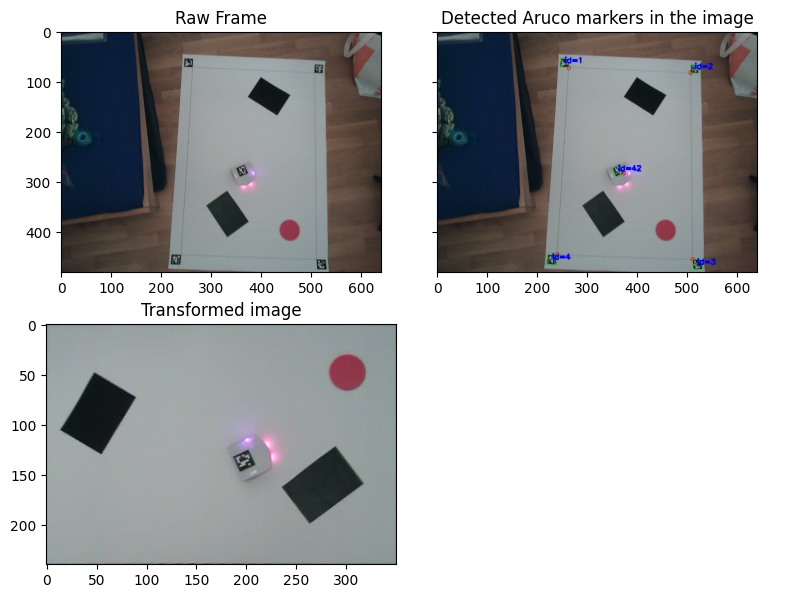

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from src.vision.helpers import get_corner, perspective_transform, Hyperparameters, read_yaml

example_img_path = "media/example_map.jpg"
frame = cv2.imread(example_img_path)
global_corners = [None, None, None, None]
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
detector = cv2.aruco.ArucoDetector(aruco_dict, cv2.aruco.DetectorParameters())
hyperparams = Hyperparameters(read_yaml("./src/vision/example_values.yml"))

# This function is taken from src/vision/camera.py and modified to make it work without
# the class context.
def _find_corners(frame, aruco_detecter, show=False):
    """
    Detects the aruco markers of the corners and updates the position

    Args:
        show (bool): If True shows the frame with drawn markers. Default: False
    """
    if show:
        img = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, rejected = aruco_detecter.detectMarkers(gray)
    if ids is not None:
        # the 4 corner of our map have ids 1,2,3,4
        for i, id in enumerate(ids):
            if id >= 1 and id <= 4:  # only consider corner markers
                global_corners[id[0]-1] = get_corner(corners[i])
        if show:
            cv2.aruco.drawDetectedMarkers(img, corners, ids)
    
    if show:
        return img
    
    
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey='row')  
axes[0, 0].set_title("Raw Frame")
axes[0, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Detected Aruco markers in the image")
markers = _find_corners(frame, detector, show=True)
axes[0, 1].imshow(cv2.cvtColor(markers, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Transformed image")
warped = perspective_transform(frame, global_corners, hyperparams.map_size[0], hyperparams.map_size[1])
axes[1, 0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
axes[1, 1].axis('off')
# save warped image
cv2.imwrite("media/warped_map.jpg", warped)
plt.tight_layout()
plt.show()

### Global obstacles

The global (black) obstacles are extracted from the imag of the map by:
1. thresholding the image to extract the black pixels
2. using a canny edge detector to find the edges
3. finding the contours and filtering them by area

**Thresholding**:

Thresholding is the simplest method of image segmentation where every pixel value above, below or within certain thresholds is set to a certain value. As our obstaces are black, we threshold on the BGR color space and set every pixel with a value below a certain threshold to black. The extracted obstacles appear now as white on a binary image. 
The thresholding step has three hyperparameters, one for each color channel.

__Canny Edge Detection__:

The Canny edge detector is an algorithm to detect various types of edges in an image. We used it to detect the edges of the binary image of the obstacles.

__Contours__:

From the edges we can find the contour of the obstacle, which is a set of boundary points of the obstacle. Since the _findContours_ function in opencv is sensitive to non-closed contours, we use a morphology operation to close the contours before applying the function. This step significantly improved the robustness of the contour detection.
To filter for noise we only keep contours with an area above a certain threshold.

The function `src/vision/camera.py::_extract_obstacles()` contains the code reuiqred for this step and saves a map with the detected obstacles drawn on it.

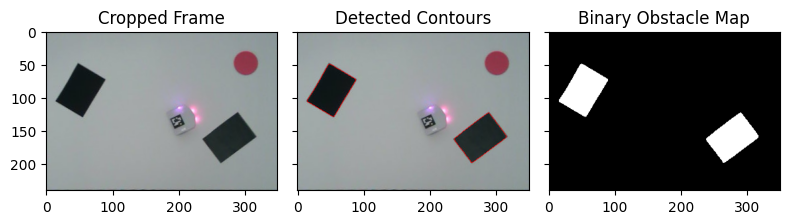

In [ ]:
def _extract_obstacles(cropped_img, hyperparams: Hyperparameters, show_warped: bool = False):
    """
    Thresholds the current frame to see the black obstacles.

    Args:
        show_warped (bool): If True shows the cropped image with drawn contours. 
                            Default: False.
    """
    warped = cropped_img.copy()
    thresholded = cv2.inRange(warped, (0, 0, 0), 
                                (hyperparams.obstacles.blue, 
                                hyperparams.obstacles.green,
                                hyperparams.obstacles.red))
    
    canny = cv2.Canny(thresholded, 94, 98, apertureSize=3)
    kernel = np.ones((hyperparams.obstacles.kernel_size, 
                      hyperparams.obstacles.kernel_size), np.uint8)
    morph = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filter controus by area
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > hyperparams.obstacles.area]
    map = np.zeros_like(warped, dtype=np.uint8)
    
    cv2.drawContours(map, contours, -1, (255, 255, 255), cv2.FILLED)
    if show_warped:
        cv2.drawContours(warped, contours, -1, (0, 0, 255), 1)
        return warped, map
    return map

fig, axes = plt.subplots(1, 3, figsize=(8, 6), sharey='row')

axes[0].set_title("Cropped Frame")
axes[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

axes[1].set_title("Detected Contours")
contours, map = _extract_obstacles(warped, hyperparams, show_warped=True)
axes[1].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))

axes[2].set_title("Binary Obstacle Map")
axes[2].imshow(cv2.cvtColor(map, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

### Goal Position

To find the goal in the map we use a similar approach as before with different thresholds for BGR color space. As our goal is red we want the red channel to be above a certain value and the blue and green channel to be below a certain value. The goal is then the center of the contour in the image.



Goal position: [302, 49]


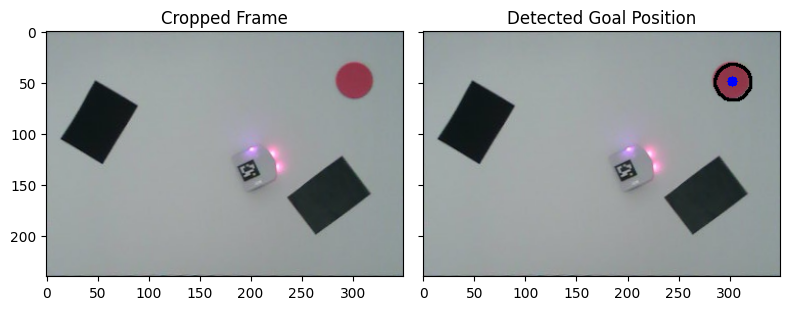

In [ ]:
def _extract_goal(cropped_img, hyperparams: Hyperparameters, show_warped: bool = False):
        """
        Thresholds the current frame to extract the goal position.

        Args:
            show_warped (bool): If True shows the cropped image with drawn contour. 
                                Default: False.
        """
        warped = cropped_img.copy()
        thresholded = cv2.inRange(warped, (0, 0, hyperparams.goal.red), 
                                    (hyperparams.goal.blue, 
                                     hyperparams.goal.green,255))
        
        canny = cv2.Canny(thresholded, 94, 98, apertureSize=3)
        kernel = np.ones((hyperparams.goal.kernel_size, 
                          hyperparams.goal.kernel_size), np.uint8)
        morph = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel, iterations=2)

        contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # filter controus where area < 500
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > hyperparams.goal.area]
        if contours:
            M = cv2.moments(contours[0])
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            goal_position = [cx, cy]
        
        if show_warped:
            cv2.drawContours(warped, contours, -1, (0, 0, 0), 2)
            cv2.circle(warped, goal_position, 5, (255, 0, 0), cv2.FILLED)
            return warped, goal_position
 
contours, goal = _extract_goal(warped, hyperparams, show_warped=True)
print(f"Goal position: {goal}")

fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey='row')

axes[0].set_title("Cropped Frame")
axes[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

axes[1].set_title("Detected Goal Position")
axes[1].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

### Robot Position

The robot position is found by detection the arcuo marker with id 42 which is taped on top of the robot. The postion of the robot is the center of the marker, whereas the orientation is the angle formed between the marker and the x-axis. 

The center and orientation can be calculated from the four corners of the markers (given by the aruco library) as follows:

<img src="./media/robot_pose.png" alt="Robot Pose Calculation" width="600"/>

As the aruco marker is not detected in every frame and the orientation is influenced by noise, we use a moving average filter to smoothen the results. In case the the robot is not detected for several consecutive frames, the function returns `np.nan` for the position and orientation. This serves as a flag for the Kalman filter to ignore the measurement in case the camera is hidden.
The specific code can be found [here](src/vision/measurements.py).

The function `src/vision/camera.py::_extract_robot_pose()` contains the code required for this step.

Robot position: [197.5 136. ], Robot orientation: 23.63°


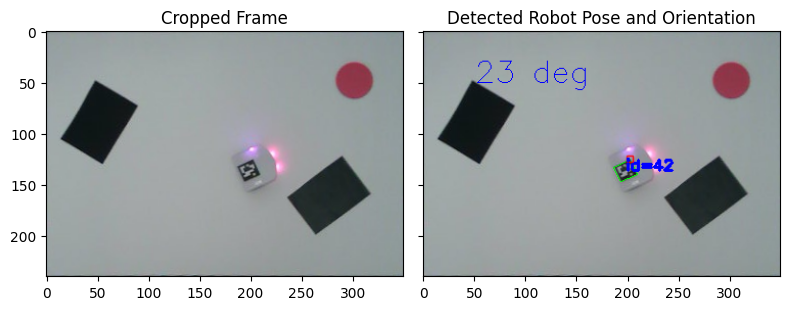

In [ ]:
from src.vision.measurements import Orientation, Position
def _extract_robot_pose(cropped_img, aruco_detector, robot_orientation: Orientation, 
                        robot_position: Position, show: bool = False):
    """
    Extracts the robot pose from latest frame
    Args:
        show (bool): If True shows the found aruco marker
    """
    warped = cropped_img.copy() 
    if show:
        img = warped.copy()
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

    corners, ids, rejected = aruco_detector.detectMarkers(gray)
    if ids is not None:
        # the 4 corner of our map have ids 1,2,3,4
        for i, id in enumerate(ids):
            if id == 42:  # only consider corner markers
                c1 = corners[0][0][0].astype(int)
                c2 = corners[0][0][1].astype(int)
                c3 = corners[0][0][2].astype(int)
                center = np.mean([c1, c3], axis=0)
                p = np.mean([c1, c2], axis=0)
                # angle = np.arctan2((center-p)[1], (p-center)[0])
                robot_orientation.update(center-p)
                robot_position.update(center)
            if show:
                cv2.aruco.drawDetectedMarkers(img, corners, ids)
    else:
        # if no aruco marker found update with nan
        robot_position.update([np.nan, np.nan])
        robot_orientation.update([np.nan, np.nan])
        
    if show:
        if not np.isnan(robot_orientation.value):
            cv2.putText(img, str(np.degrees(robot_orientation.value).astype(int))+" deg", (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0))
        return img
    
robot_orientation = Orientation()
robot_position = Position()
robot_pose = _extract_robot_pose(warped, detector, robot_orientation, robot_position, show=True)
print(f"Robot position: {robot_position.value}, Robot orientation: {np.degrees(robot_orientation.value):.2f}°")

fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey='row')

axes[0].set_title("Cropped Frame")
axes[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

axes[1].set_title("Detected Robot Pose and Orientation")
axes[1].imshow(cv2.cvtColor(robot_pose, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

### Visualization

The class camera provides a function `src/vision/camera.py::visualize_map()` which draws the map with all the detected elements on it, as well as the estimated robot pose from the kalman filter and the optimal path if inialized. The final visualization can be seen in the gif below.

<img src="./media/example_visualization.gif" alt="Vision Visualization" width="300"/>

### A little word about hyperparameters

Vision depends strongly on the lightning conditions, which change from place to place but also during the day. To ease the tuning for those hyperparameters we created a small script `scripts/threshold_finder.py` which allows to find the correct combination of parameters with live feedback from the camera. The thresholds found are then stored in [src/vision/values](src/vision/values.yml) and loaded during runtime of the main program. 

A screenshot of the script can be seen below:

<p align="top">
    <img src="media/threshold_finder.png" alt="Threshold Finder" width="600"/> 
    <img src="media/threshold_finder_settings.png" alt="Threshold Finder Settings" width="400"/>
</p>


## Global Path Planning

Code required to execute vision module independently. Don't describe the code but explain what is behind it (i.e. theory, algorithms, measurements, choice of parameters, etc.).

CITE YOUR SOURCES

After the extracting the binary matrix of navigable terrain, as well as the positions of the robot and the target, we inflate the obstacles (explain the algo) by the size equal to the maximum distance between the robot's center of rotation and its side. This ensures that for all possible poses the robot does not collide with obstacles.

[code: obstacle inflation]
[plot: inflated obstacles] 


After the matrix is calculated, we use the A-star algorithm to find the shortest path between the the robot and target positions. (optional: intermedaite checkpoint elimination by Sara).

We then delete all the redundant points from the checkpoint list using a "visibility algorithm" (elaborate further). NOTE: why A-star before visibility and not the other way around? Because we don't assume polygonal obstacles so it's not necessarily more robust nor efficient in computation. In the end we are left with a path optimized in terms of both distance and number of checkpoints: 

[code: visibility algo]
[plot: final checkpoints list]
[plot: final checkpoints list over camera image]





## Kalman Filter

We decided to implement an Extended Kalman Filter (EKF) for robot localization. The EKF estimates the robot's position, orientation, and motion parameters based on sensor inputs (camera data) and motor controls.

### EKF Components

#### 1. State Vector
The state vector $\mu$ represents the robot's estimated state at any given time:

$$ \mu = \begin{bmatrix} x \\ y \\ \theta \\ v \\ \omega \end{bmatrix}$$

Where:
- \(x, y\): Current position in pixels
- \($\theta$\): Current orientation in radians
- \(v\): Linear velocity (in pixels/second)
- \($\omega$\): Angular velocity (in radians/second)

The equation of motion of the robot is:

$$ \mu_{est}  = A \cdot \mu^t + B \cdot U^t $$

Where A is the state transition matrix and B is the control input matrix:
$$ A = \begin{bmatrix}  1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0  \end{bmatrix}$$

$$ B = \begin{bmatrix} dt*cos(\theta) & 0 \\ dt*sin(\theta) & 0 \\ 0  & dt \\ 1 & 0 \\ 0 & 1 \end{bmatrix}$$


#### 2. Time Management
In the Matrices above, $dt$ is the difference in time (s) between 2 iterations of the EKF. It was calculated with the time library by saving the time of the previous iteration and checking the time when calling the filter.


#### 3. Variances

In the implementation of the Kalman filter, two key variance matrices, R and Q, are utilized to handle the measurement and process noise, respectively. These matrices are crucial for improving the filter’s estimation accuracy by quantifying the uncertainties involved.

##### 3.1. R matrix 

The matrix R models the uncertainty in the sensor measurements, which includes the GPS position data as well as the velocities of the robot. After conducting calibration experiments, the standard deviations of the various variables were estimated. The matrix R takes the following form:
$$ R = \begin{bmatrix} 0.25 & 0 & 0 & 0 & 0 \\ 0 & 0.25 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 5.02 & 0 \\ 0 & 0 & 0 & 0 & 0 \end{bmatrix} $$

with the x and y position variances taken from series 8 of the course and the velocity variance is calculated from the series 8 velocity variance with a conversion from mm to pixels.

##### 3.2. Q matrix

The matrix Q represents the process noise, accounting for the uncertainty in the robot’s motion model and the inherent variability in its movement. It incorporates the estimated standard deviations for linear and angular velocities. The matrix Q is given by:

$$ Q = \begin{bmatrix} 0.2 & 0 & 0 & 0 & 0 \\ 0 & 0.2 & 0 & 0 & 0 \\ 0 & 0 & 0. & 0 & 0 \\ 0 & 0 & 0 & 5.02 & 0 \\ 0 & 0 & 0 & 0 & 0 \end{bmatrix} $$

with the x and y position variances taken from series 8 again. 

#### 4. Motor values and system state

The motor value matrix U is 2x1 and holds the values of speed and angular velocities calculated from the motor values. The system state matrix Y is 5x1 and holds the position, orientation, speed and angular velocity from the camera measurements


#### 5. Jacobian

The Jacobian G of the filter is calculated using the orientation and speed of the robot.

$$ G = \begin{bmatrix} 1 & 0 & dt*sin(\theta)*v & dt*cos(\theta)*v & 0 \\ 0 & 1 & dt*cos(\theta)*v & dt*sin(\theta)*v & 0 \\ 0 & 0 & 1 & 0 & dt \\ 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 1 \end{bmatrix} $$


### General EKF system

- Prediction of State Vector: 
$$ \mu_{est}  = A \cdot \mu^t + B \cdot U^t $$

- Calculation of the Prediction Covariance
$$\sigma_{est} = G \cdot \sigma \cdot G^T + Q$$

#### Condition: camera blocked
If the camera is blocked, the input of the camera into the kalman filter will all be NaN and the filter will return the values predicted above.

#### Condition: camera not blocked
If the camera is not blocked, the algorithm continues.

- Update of the Kalman Gain :

K is the Kalman Gain of the System
$$S = H \cdot \sigma_{est} \cdot H^T + R$$

$$K = \sigma_{est} \cdot S^{-1}$$

- The kalman gain is now used to adjust the values of the prediction:
$$ \mu_{est} = \mu_{est} + K \cdot(Y - \mu_{est})$$

- The kalman gain is also used to adjust the covariance:

$$ \sigma = I - K \cdot H \cdot\sigma_{est} $$
Where I is a 5x5 identity matrix.


### Discussion:
During the testing of the kalman filter, and mainly when testing without the camera, we came across a few issues with the original implementation.

#### Inconsistent Speed
The left and right motor speeds were oscillating around the actual values, which led the Kalman filter to interpret these fluctuations as changes in orientation, even when the robot was moving in a straight line. To address this issue, we opted to use the motor's target speed directly as the input for the Kalman filter. This approach is similar to averaging the speed measurements from the motors, providing a more stable estimate of the robot's motion and reducing the unintended orientation adjustments caused by speed variations.

#### Turn angle calculation

The solution to the previous issue introduced a new challenge. As the robot begins to turn and accelerates, the Kalman filter receives the speed input during the acceleration phase. This results in an inaccurate angle calculation since the speed is still increasing as the robot turns. To address this, we introduced a constant offset in the angle calculation. This adjustment compensates for the ongoing acceleration, providing a more accurate estimation of the robot's orientation during turns.


### Kalman Filter Demonstation:
The video below demonstrates the functionality of the Kalman filter, particularly in scenarios where the camera is unavailable or fails to detect the Thymio. Despite the lack of camera input, the Kalman filter effectively tracks the robot's position and orientation. In the footage, the green line indicates the intended trajectory, and the Thymio successfully follows a path closely aligned with it, showcasing the filter's reliability and accuracy in maintaining the robot's navigation.

TODO: add the video of a run without the camera 

<img src="./media/full kalman.gif" alt="Kalman Filter" width="300"/>


### Kalman Filter Evaluation:
The video below captures a test run where the camera's visibility alternates between obstruction, then allowed to detect the robot, and obstruction again. The video is accelerated by a factor 2.2:

<img src="./media/kalman.gif" alt="Kalman Filter" width="300"/>

To analyze the Kalman filter's effectiveness, we plotted the positions and angles estimated by both the Kalman filter and the camera throughout the run. These plots compare how the system performs with and without camera data:

<p align="top">
    <img src="media/Kalman_position.png" alt="Kal_pos" width="500"/> 
    <img src="media/Kalman_angle.png" alt="Kal_ang" width="500"/>
</p>

From these visualizations, we observe that when the camera regains visibility, it adjusts the Kalman filter’s estimates to a more accurate position. However, even without camera input, the Kalman filter calculations remain close to the corrected values, demonstrating the robustness of the filter in maintaining reliable state estimation.


Sources: Basics of mobile robotics: Solution week 8 - Kalman Filter 
</span>

## Motor Control

<span style="color:red">
Code required to execute vision module independently. Don't describe the code but explain what is behind it (i.e. theory, algorithms, measurements, choice of parameters, etc.).

CITE YOUR SOURCES
</span>

This paragraph will describe the general structure we use to control the motors of the Thymio and how we implemented the global navigation, where the robot follows a path found by the global path planning algorithm.

To ease the communication with the Thymio we created a class `Driver` which serves as an interface and communicates over the aseba protocol.

To follow a path we minimize the error of the angle between the orientation of the robot and the direction betwen the robot and the next checkpoint. We differentiate between two cases:
1. The angle is bigger than 10°: We rotate the robot in place until the angle is smaller than 10°.
2. The angle is smaller than 10°: We move the robot forward until the next checkpoint is reached while correcting the orientation.

This logic is implemented in [Driver::move_to_checkpoint()](src/motion_control/driving.py) and copied below.

```python
    def move_to_checkpoint(self, robot_pose: tuple[np.ndarray, float], checkpoint: np.ndarray):
        """
        Function to move the robot to a given point in the map. P control on the
        angle is used to steer the robot towards the checkpoint.

        Args:
            robot_pose (tuple): Current robot pose as a tuple of (position, orientation)
            checkpoint (np.ndarray): Coordinates of the checkpoint [x, y]
        """
        if np.isnan(robot_pose[0]).any():
            return

        dx = checkpoint[0] - robot_pose[0][0]
        dy = robot_pose[0][1] - checkpoint[1]
        
        dir = np.arctan2(dy, dx)

        # angle between robot's orientation and direction to the checkpoint
        angle = dir - robot_pose[1]

        # Normalize angle to [-pi, pi] (i.e. alwas turn into the shortest direction)
        if (abs(angle) > np.pi):
            angle = angle - 2*np.pi*np.sign(angle)

        # If the angle is too large, turn in place, here we don't do local avoidance
        # as we turn on the spot
        if abs(angle) > np.deg2rad(10):
            speed = int(30 * np.sign(angle) + angle * 120)
            self.set_motor_speeds(-speed, speed)
        
        # Otherwise, move forward with a P control to steer towards the checkpoint
        else:
            gain = self.pid(angle)
            l_speed = 150 + gain
            r_speed = 150 - gain

            self.set_motor_speeds(int(l_speed), int(r_speed))
```


**Note**: As we are minimizing the angle error between the orientation of the robot and the _direction_ of the robot to the next checkpoint, the robot will not always follow the path perfectly. It rather moves in a straight line towards the next checkpoint. In case of an offset from the path - caused by noisy measurements, obscured camera vision or local obstacles - the robot will not converge to the path before reaching the next checkpoint. 
As our map is relatively simple and small, this behaviour is sufficient. For more complex maps or bigger environments, a more sophisticated control algorithm should be used. A possibility would be to minimize the angle between the robot and a point in front of the robot _on_ the path.

An example of the robot following a path can be seen in the gif below, which has been accelerated by factor 2:

<img src="./media/global_run.gif" alt="Path following" width="300"/>

## Local Obstacle Avoidance

We would like our robot to handle unexpected objects that may appear randomly on its way to the next checkpoint. In order to do that, we used the same approach as in the homeworks (Sessions 3 and 4). We took into account the 5 front sensors, that we get from the Thymio's ```prox.horizontal``` values, and we perform a weighted sum of sensor inputs using predefined weights to determine motor speeds. We have fine-tuned our hyperparameters to adapt them to our controller. For example, we divide our proximity sensors by 400 and keep the weights ranging from 2.5 to 10+. The weights for the right and left motors are asymmetric in order for the robot to avoid the obstacle. This setting of parameters allows us to have better and predictable outputs of the motor speeds as well as allowing the Thymio to completely turn away from the obstacle before resuming to global navigation.
 
However, this can sometimes result in repetitive iterations between global and local navigation, causing less smooth movement. To address this, we adapted our approach. Once the robot detects an obstacle, it computes the distance it needs to travel to clear it. More precisely, the robot advances by a distance equal, in cm, to its own width divided by two plus the number of activated sensors. The logic here is that if only one sensor is activated, the obstacle is likely near the edge of the robot, so only a small adjustment is needed to bypass it and return to the original path without encountering the obstacle again.

To further smooth the navigation, after traversing the computed distance, the robot turns 45 degrees in the opposite direction of its previous turn. This angle, determined through testing and fine-tuning, allows the robot to transition back to global navigation in a smoother way.

<div style="display: flex; align-items: center; justify-content: center; gap: 20px;">
    <img src="media/smooth_local_nav_schema.jpg" alt="Smooth Local Navigation Schema" width="600"/>
    <img src="./media/gif_local_nav.gif" alt="Local Obstacle Avoidance" width="300"/>
</div>


Even without these modifications, the robot can effectively navigate around obstacles. However, our enhancements make the navigation process smoother, which is something we wanted to achieve.

### State transition
To switch from global to local navigation and vice-versa, we make sure that the right conditions are met. 

For instance, if **any** of the front sensors is higher than a set threshold ```obstThrH```, that means that we're very close to a physical object. We, hence, switch to local navigation. If **all** the sensors are below another set threshold ```obstThrL```, that means that the robot is far away from any physical object and we can safely get back to global navigation. 

The reason why we have different thresholds is because we would like to avoid unnecessary oscillations.
- The higher threshold ```obstThrH``` ensures that we only switch to local navigation when an obstacle is genuinely close and requires immediate attention.
- The lower threshold ```obstThrL``` ensures that we stay in local navigation until the environment is sufficiently clear, avoiding premature transitions back to global navigation.

```bash
obstThrL = 5                # low obstacle threshold to switch state local->global
obstThrH = 8.5              # high obstacle threshold to switch state global->local   

... 
    elif state == 1: # local navigation
        if all(sensor < obstThrL for sensor in obst):
            if nb_active_sensors != 0:
                # Move by the number of active sensors + half of the width of the robot
                driver.move(60 + (10 * nb_active_sensors))
            
                # Smoothing step to avoid repeated state switching
                if previous_direction == 'left':
                    driver.turn(math.pi/4)
                elif previous_direction == 'right':
                    driver.turn(-math.pi/4)
                # Move by the width of the robot
                driver.move(120) 

                nb_active_sensors = 0

            current_state = 0

    elif state == 0: # global navigation
        if any(sensor > obstThrH for sensor in obst):
            nb_active_sensors = sum(sensor > 0 for sensor in obst)
            current_state = 1

..
```

### Limitations
1. **Global obstacles:** Our implementation effectively avoids unexpected obstacles in the map but it does not take into account the global obstacles that were already present. To further improve our algorithms, we will need to analyze the matrice of the map, given by vision, and make sure that the next orientation won't lead us into uncharted territory. This is even more important with our "smoothing" phase where we advance by a set number of cm calculated according to the physical obstacle. This additional feature should also take into account the borders as well as the goal. 


2. **Rear Sensors:** We also do not take into account the two sensors in the back as we did not consider this scenario as plausible in our case. Since we will only have one physical obstacle. However, this leads our implementation to not be flexible enough to various scenarios. Adding this behaviour is easy enough. We will need to add weights for these sensors and take them into account for the calculations of of the right and left motor speeds.

## Kidnapping

In case the robot is kidnapped (i.e. picked up and moved to a different place in the map), we will recompute the path to the goal.

Our implementation uses the ground proximity sensors of the robot to detect if it has been picked up. If the sensor values are 0 (indicating that the robot is not on the ground), the robot will stop and wait for the user to place it back on the ground. Only once the robot is back on the ground and its markers are again detected by the camera, we will recompute the path to the goal. 

This behaviour can be seen on the gif here:

<img src="./media/kidnapping.gif" alt="Kidnapping example" width="300"/>

## Putting it all together

<span style="color:red">
A section which is used to run the overall project and where we can see the path chosen, where the system believes the robot is along the path before and after filtering etc… 

REFERENCE OT THE MAIN FILE.
</span>

The main file consists of two parts: the initialization and the main loop. The initialization consists of the following steps:
1. Initialize the camera
2. Initialize the map (corners, obstacles, goal, robot initial position)
3. Initialize the Kalman filter
4. Initialize the connection with the Thymio
5. Compute the optimal path

The main loop starts two independent threads:
- **th1**: Vision thread, which updates the measurements of the robot position and the robot pose obtained by the Kalman filter
- **th2**: Motor control thread, which serves as a state machine and controls the movement of the Thymio.


Here is a flow chart of the motor control state machine, that is implemented in [main.py::motor_control()](./main.py).

<img src="./media/motor_control_flowchart.svg" alt="State Machine" width="800"/>

We decided to use threads to update the camera at a higher frequency which makes the displayed video more fluid. The high frequency of updates also allows us to perform a moving average filter on the measurement of the robot pose measurement and the robot pose estimation by the Kalman filter, while keeping the motor control reasonably reactive.

## Conclusion

<span style="color:red">
What we learned, what we would do differently, what we would like to add, etc.
</span>

## References:
Used libraries:
- [OpenCV](https://opencv.org/)
- [NumPy](https://numpy.org/)
- [PyYAML](https://pyyaml.org/)
- [simple_pid](https://pypi.org/project/simple-pid/)
- [tdmclient](https://pypi.org/project/tdmclient/)
- [Matplotlib](https://matplotlib.org/)

(link documentation of used python functions that are not immediately clear)